In [ ]:
!pip install mediapipe

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from google.colab.patches import cv2_imshow
from google.colab import files
from IPython.display import Image
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import cv2
import mediapipe as mp
from keras.models import load_model
import numpy as np
import time

## Dataset pre-processing

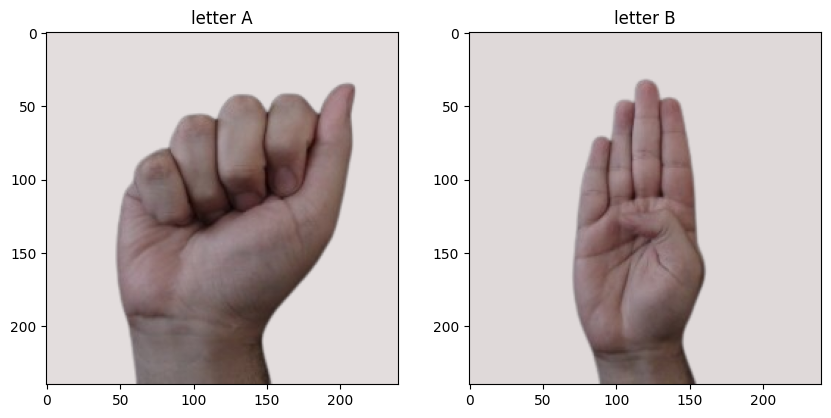

Image shape:  (240, 240, 3)


In [168]:
data_dir_A = 'hand-reader-dataset/A'
data_dir_B = 'hand-reader-dataset/B'
sampleA = cv2.imread(data_dir_A + '/00000-removebg-preview.png')
sampleA = cv2.cvtColor(sampleA, cv2.COLOR_BGR2RGB)
sampleB = cv2.imread(data_dir_B + '/01000-removebg-preview.png')
sampleB = cv2.cvtColor(sampleB, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(sampleA)
axes[0].set_title('letter A')
axes[1].imshow(sampleB)
axes[1].set_title('letter B')
plt.show()

print('Image shape: ', sampleA.shape)

In [169]:
samplesA = [f for f in listdir(data_dir_A) if isfile(join(data_dir_A, f))]
samplesB = [f for f in listdir(data_dir_B) if isfile(join(data_dir_B, f))]
dataset = np.empty((100, 240, 240))

i = 0
for file in samplesA:
    img_array = cv2.imread(join(data_dir_A, file))
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY) # grayscale
    
    dataset[i, :, :] = img_array
    i += 1
for file in samplesB:
    img_array = cv2.imread(join(data_dir_B, file))
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY) # grayscale
    dataset[i, :, :] = img_array
    i += 1

dataset = dataset.reshape(-1,240,240,1)
print('Dataset shape: ', dataset.shape)

# A --> 0
# B --> 1
labels = np.array([0] * 50 + [1] * 50)

Dataset shape:  (100, 240, 240, 1)


In [170]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.15, random_state=314)
print('Train set shape: ', X_train.shape)
print('Test set shape: ', X_test.shape)

Train set shape:  (85, 240, 240, 1)
Test set shape:  (15, 240, 240, 1)


In [171]:
# Data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 0,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
train_datagen.fit(X_train)
X_test = X_test / 255

## Model definition and training

In [172]:
model=Sequential()
model.add(Conv2D(128, kernel_size=(5,5), strides=1, padding='same', activation='relu', input_shape=(240, 240, 1)))
model.add(MaxPool2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(32, kernel_size=(2,2), strides=1, activation='relu', padding='same'))
model.add(MaxPool2D((2,2), 2, padding='same'))
model.add(Conv2D(8, kernel_size=(2,2), strides=1, activation='relu', padding='same'))
model.add(MaxPool2D((2,2), 2, padding='same'))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 240, 240, 128)     3328      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 120, 120, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 120, 120, 32)      16416     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 60, 60, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 60, 60, 8)         1032      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 30, 30, 8)       

In [173]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the log dir in order to save the checkpoint file
logdir = os.path.join(os.curdir, "my_logs", "run_{}".format(time.time()))

# Early stopping: in Keras it is managed by using the callbacks argument
callbacks = [keras.callbacks.TensorBoard(logdir),
             keras.callbacks.EarlyStopping(patience=10), 
             #Saving the checkpoints file allows to load the "best" model when the Early 
             #stopping detect that the generalization error degrade (after 'patience' epochs)
             keras.callbacks.ModelCheckpoint("sign-mnist.h5", save_best_only=True)]


In [ ]:
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=20), 
                    epochs=50, validation_data=(X_test, y_test), shuffle=1,
                    callbacks=callbacks)
model.save('hand-reader.h5')
files.download('hand-reader.h5')

## Webcam frame test

In [3]:
model = load_model('hand-reader.h5')

mphands = mp.solutions.hands
hands = mphands.Hands()
mp_drawing = mp.solutions.drawing_utils

#### Camera Utils

In [100]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [101]:
def bounding_box(frame):
    h, w, c = frame.shape
    framergb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    result = hands.process(framergb)
    hand_landmarks = result.multi_hand_landmarks
    if hand_landmarks:
        for handLMs in hand_landmarks:
            x_max = 0
            y_max = 0
            x_min = w
            y_min = h
            for lm in handLMs.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                if x > x_max:
                    x_max = x
                if x < x_min:
                    x_min = x
                if y > y_max:
                    y_max = y
                if y < y_min:
                    y_min = y
            y_min -= 20
            y_max += 20
            x_min -= 20
            x_max += 20
        return x_min, y_min, x_max, y_max, handLMs
        
    else:
        return 0, 0, 0, 0, []

In [108]:
def grey_cropping(frame, display=True):
    x_min, y_min, x_max, y_max, _ = bounding_box(frame)

    # Extend the bounding to obtain a square
    if x_max - x_min < y_max - y_min:
        x_mid = (x_max + x_min)/2
        y_mid_len = (y_max - y_min)/2
        x_min = int(max(x_mid - y_mid_len, 0))
        x_max = int(min(x_mid + y_mid_len, 640))
    elif x_max - x_min > y_max - y_min:
        x_mid_len = (x_max - x_min)/2
        y_mid = (y_max + y_min)/2
        y_min = int(max(y_mid - x_mid_len, 0))
        y_max = int(min(y_mid + x_mid_len, 480))

    analysisframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    analysisframe = analysisframe[y_min:y_max, x_min:x_max]
    analysisframe = cv2.resize(analysisframe,(240, 240))
    if display:
      cv2_imshow(analysisframe)
    analysisframe = analysisframe.reshape(-1, 240, 240, 1)

    return analysisframe

In [117]:
def real_time_box(frame, x_min, y_min, x_max, y_max):
    # Extend the bounding to obtain a square
    if x_max - x_min < y_max - y_min:
        x_mid = (x_max + x_min)/2
        y_mid_len = (y_max - y_min)/2
        x_min = int(max(x_mid - y_mid_len, 0))
        x_max = int(min(x_mid + y_mid_len, 640))
    elif x_max - x_min > y_max - y_min:
        x_mid_len = (x_max - x_min)/2
        y_mid = (y_max + y_min)/2
        y_min = int(max(y_mid - x_mid_len, 0))
        y_max = int(min(y_mid + x_mid_len, 480))

    analysisframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    analysisframe = analysisframe[y_min:y_max, x_min:x_max]
    analysisframe = cv2.resize(analysisframe,(240, 240))
    analysisframe = analysisframe.reshape(-1, 240, 240, 1)
    return analysisframe

#### Test: A sample

In [ ]:
try:
  filename = take_photo('A.jpg')
  print('Saved to {}'.format(filename))
except Exception as err:
  print(str(err))

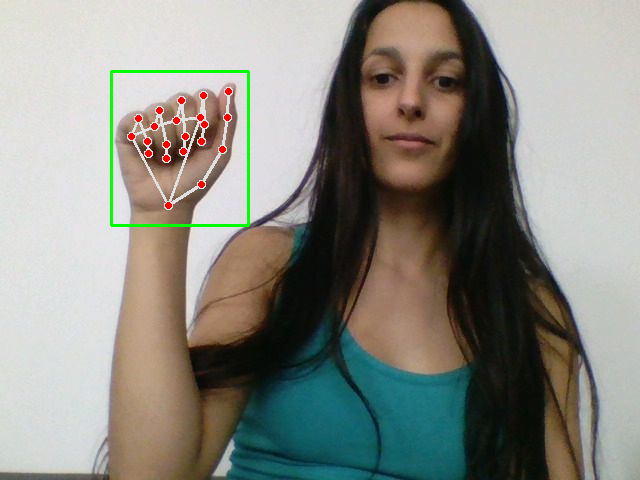

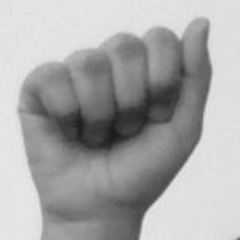

Prediction:  0
Confidence:  100.0


In [6]:
frame = cv2.imread('A.jpg')

x_min, y_min, x_max, y_max, handLMs = bounding_box(frame)
frame_with_bounding = frame.copy()
cv2.rectangle(frame_with_bounding, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
mp_drawing.draw_landmarks(frame_with_bounding, handLMs, mphands.HAND_CONNECTIONS)
cv2_imshow(frame_with_bounding)

analysisframe = grey_cropping(frame)

pred_prob = model.predict(analysisframe, verbose = 0)
pred_class = int(np.round(pred_prob))
print('Prediction: ', pred_class)
if pred_class == 0:
    print('Confidence: ', (1 - pred_prob.item()) * 100)
else:
    print('Confidence: ', pred_prob.item() * 100)

#### Test: B sample

In [ ]:
try:
  filename = take_photo('B.jpg')
  print('Saved to {}'.format(filename))
except Exception as err:
  print(str(err))

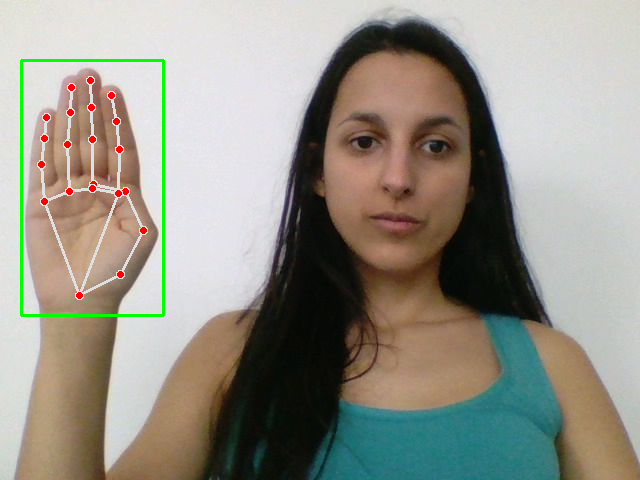

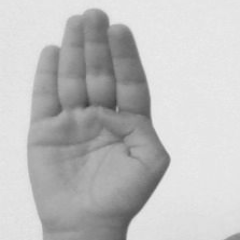

Prediction:  1
Confidence:  100.0


In [104]:
frame = cv2.imread('B.jpg')

x_min, y_min, x_max, y_max, handLMs = bounding_box(frame)
frame_with_bounding = frame.copy()
cv2.rectangle(frame_with_bounding, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
mp_drawing.draw_landmarks(frame_with_bounding, handLMs, mphands.HAND_CONNECTIONS)
cv2_imshow(frame_with_bounding)

analysisframe = grey_cropping(frame)

pred_prob = model.predict(analysisframe, verbose = 0)
pred_class = int(np.round(pred_prob))
print('Prediction: ', pred_class)
if pred_class == 0:
    print('Confidence: ', (1 - pred_prob.item()) * 100)
else:
    print('Confidence: ', pred_prob.item() * 100)

## Real-time test

#### Video Utils

In [160]:
# JavaScript to properly create our live video stream using our webcam as input
from google.colab.output import eval_js

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: black; font-weight: bold;">' +
          'When finished, click the bottom below to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      const stop_demo = document.createElement('button');
      stop_demo.textContent = 'STOP DEMO';
      div.appendChild(stop_demo);
      stop_demo.onclick = () => { shutdown = true; };

      video.srcObject = stream;

      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [106]:
# function to convert the JavaScript object into an OpenCV image
import PIL
import io
from base64 import b64decode, b64encode

def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

#### Test

In [182]:
# start streaming video from webcam
video_stream()

# label for video
label_html = 'Capturing...'

# initialze bounding box to empty
bbox = ''
history = [np.nan, np.nan]

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    h, w, c = frame.shape
    bbox_array = np.zeros([h, w, c+1], dtype=np.uint8)
    bbox_array = cv2.rectangle(bbox_array, (0, 0), (640, 640), (255, 255, 255), 2)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

    # bounding box and prediction
    x_min, y_min, x_max, y_max, _ = bounding_box(frame)
    if _ != []:
        analysisframe = real_time_box(frame, x_min, y_min, x_max, y_max)
        pred_prob = model.predict(analysisframe, verbose = 0)
        label = int(np.round(pred_prob))
        history.append(label)
        
        if history[-2:] == [0, 1] or history[-2:] == [1, 0]:
            bbox_array = cv2.rectangle(bbox_array, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
            bbox_array = cv2.putText(bbox_array, "HELP", (x_min, y_min-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
            # convert overlay of bbox into bytes
            bbox_bytes = bbox_to_bytes(bbox_array)
            # update bbox so next frame gets new overlay
            bbox = bbox_bytes

<IPython.core.display.Javascript object>